In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
import seaborn as sns
import pymc3 as pm
import arviz as az

%matplotlib inline

In [20]:
np.random.seed(0)
X, y = make_moons(n_samples=200, noise=0.1)

(200, 3)

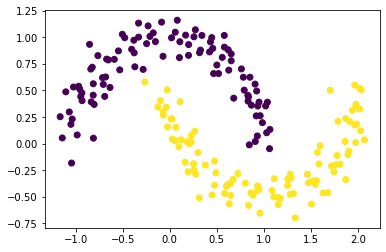

In [21]:
plt.scatter(X[:, 0], X[:, 1],c=y)
X_concat = np.hstack((np.ones((len(y), 1)), X))
X_concat.shape

In [25]:
basic_model = pm.Model()
shapes = [4, 5, 1]

with basic_model:
    w1 = pm.Normal("w1", mu=1, sigma=10, shape=(X_concat.shape[1], shapes[0]))
    w2 = pm.Normal("w2", mu=2, sigma=10, shape=(shapes[0], shapes[1]))
    w3 = pm.Normal("w3", mu=3, sigma=10, shape=(shapes[1], shapes[2]))
                   
    X_ = pm.Data('features', X_concat)
    y_ = pm.Data('targets', y)
    # Expected value of outcome
    
    a_1 = pm.math.sigmoid(pm.math.dot(X_, w1))
    a_2 = pm.math.sigmoid(pm.math.dot(a_1, w2))
    a_3 = pm.math.sigmoid(pm.math.dot(a_2, w3))
    
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", p=a_3, observed=y_)

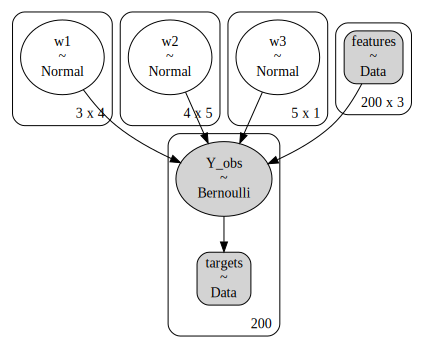

In [26]:
pm.model_to_graphviz(basic_model.model)

In [27]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'w1': array([[0.95893971, 0.95893971, 0.95893971, 0.95893971],
        [1.02058225, 1.02058225, 1.02058225, 1.02058225],
        [0.99207536, 0.99207536, 0.99207536, 0.99207536]]),
 'w2': array([[1.9852561, 1.9852561, 1.9852561, 1.9852561, 1.9852561],
        [1.9852561, 1.9852561, 1.9852561, 1.9852561, 1.9852561],
        [1.9852561, 1.9852561, 1.9852561, 1.9852561, 1.9852561],
        [1.9852561, 1.9852561, 1.9852561, 1.9852561, 1.9852561]]),
 'w3': array([[6.03054909e-07],
        [6.03054909e-07],
        [6.03054909e-07],
        [6.03054909e-07],
        [6.03054909e-07]])}

In [28]:
with basic_model:
    inference = pm.ADVI()
    approx = pm.fit(n=300, method=inference)

Finished [100%]: Average Loss = 2.9672e+05


In [29]:
trace = approx.sample(draws=50)

In [30]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(20,return_inferencedata=False,tune=10)

Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w3, w2, w1]


Sampling 4 chains for 10 tune and 20 draw iterations (40 + 80 draws total) took 12 seconds.
/home/patel_zeel/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.15, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9838913653589186, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probabil

/home/patel_zeel/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'w1'}>,
        <AxesSubplot:title={'center':'w1'}>],
       [<AxesSubplot:title={'center':'w2'}>,
        <AxesSubplot:title={'center':'w2'}>],
       [<AxesSubplot:title={'center':'w3'}>,
        <AxesSubplot:title={'center':'w3'}>]], dtype=object)

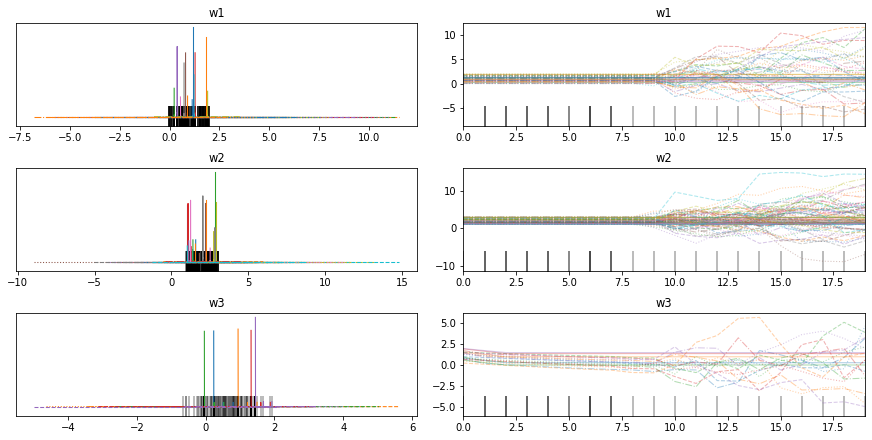

In [31]:
az.plot_trace(trace);

In [33]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [34]:
X_test = np.c_[xx.ravel(), yy.ravel()]
X_test_concat = np.hstack((np.ones((len(X_test), 1)), X_test))
X_test_concat.shape

(2067, 3)

In [35]:
with basic_model:
    pm.set_data({'features': X_test_concat})
    posterior = pm.sample_posterior_predictive(trace)

In [38]:
Z = posterior['Y_obs']
posterior['Y_obs'].shape, X_test_concat.shape

((80, 2067, 200), (2067, 3))

In [39]:
for i in range(len(Z))[:500]:
    plt.contour(xx, yy, Z[i].reshape(xx.shape), alpha=0.01)
plt.scatter(X[:, 0], X[:, 1],c=y, zorder=10)

ValueError: cannot reshape array of size 413400 into shape (39,53)

FOllowing code inspired from": https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

ValueError: cannot reshape array of size 413400 into shape (39,53)

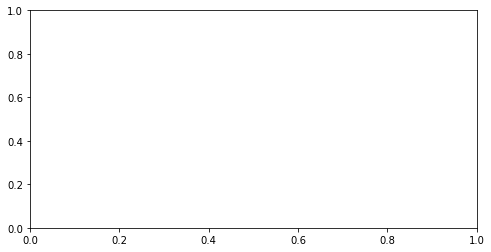

In [40]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].mean(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");


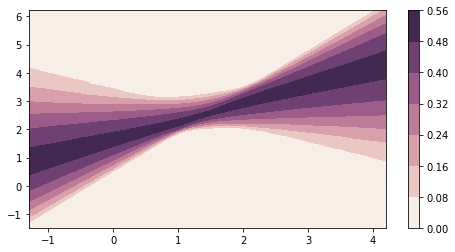

In [43]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].std(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");